# Convolutional Neural Networks
Convolutional Neural Networks (CNN's) are the methodology for image processing for neural networks. They are most commonly implmented for image classification problems, but can be modified to help solve even more complex problems.

CNN's work primarily by extending the concepts we talked about in the previous notebook; convolutional filters.

----

## CNN Workflow
CNN's generate identifying features of a given image by cycling through a couple of steps:
 1. Create random filters
 2. Apply filters to base image
 3. Apply activation function to filtered image
 4. Pool image into a smaller representative image
 5. Repeat
 
 ![](https://ujwlkarn.files.wordpress.com/2016/08/screen-shot-2016-08-07-at-4-59-29-pm.png?w=1493)
 
 [Another useful visualization](https://cs.stanford.edu/people/karpathy/convnetjs/demo/cifar10.html)
 
Once we have generated our feature space, through the process of iterative filtering/activation/pooling, we are ready to perform our classification step. Prior to any classification though, we need to fully connect our resulting filtered images into a single vector for analysis.
 
Once we have transformed our original image into a fully-connected vector, it can now be used for traditional classification purposes.

----

# CNN Example
To fully demonstrate the CNN pipeline we'll walk through an example using Keras and Tensorflow where we will build out a network to classify images.

To start we'll begin by exploring our dateset.
## The Dataset:
### Fashion MNIST Database
Historically the more traditional dataset for image classification is the [MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database). The MNIST dataset is a collection of handdrawn digits and is the basis for the interactive example linked above.

Since CNNs have more or less perfected the solution to the traditional MNIST dataset, there is a newer dataset that we'll use for this lecture. The [fashion MNIST dataset](https://www.wikidata.org/wiki/Q41074334), which represents 10 different clothing classes in 28x28 black and white pixel images:
 - T-shirt/top
 - Trouser
 - Pullover
 - Dress
 - Coat
 - Sandal
 - Shirt
 - Sneaker
 - Bag
 - Ankle boot
 
 <img src="https://miro.medium.com/max/1400/1*-kpgaee9X9Gm-SrQKdk_og.png"></img>

## Loading the data
Keras, like scikit-learn, has a number of preloaded datasets to work with. This means that we can simply reference the dataset using keras.

```python
from tensorflow.keras.datasets import fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
```

In [1]:
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [2]:
print(x_train[0].shape)
print(x_train[0])

(28, 28)
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   1   0   0  13  73   0
    0   1   4   0   0   0   0   1   1   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3   0  36 136 127  62
   54   0   0   0   1   3   4   0   0   3]
 [  0   0   0   0   0   0   0   0   0   0   0   0   6   0 102 204 176 134
  144 123  23   0   0   0   0  12  10   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0 155 236 207 178
  107 156 161 109  64  23  77 130  72  15]
 [  0   0   0   0   0   0   0   0   0   0   0   1   0  69 207 223 218 216
  216 163 127 121 122 146 141  88 172  66]
 [  0   0   0   0   0   0   0   0   0   1   1   1   0 2

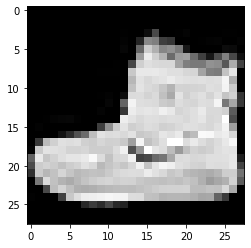

In [3]:
plt.imshow(x_train[0], cmap='gray')

In [4]:
y_train[0]

9

Given that our y labels aren't one_hot encoded, we will still need to translate them using keras's `to_categorical`. In addition, we'll need to reshape the X inputs, as Keras does expect a 3D tensor where the current `X_train/X_test` are actually 2D (28 x 28).

In [5]:
from tensorflow.keras.utils import to_categorical

# Reshaping the inputs
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1).astype('float32')
input_shape = x_train[0].shape
print(input_shape) # What is our input shape/shape of our image

# Turning the outputs into one-hot encoded representations
y_train_one = to_categorical(y_train)
y_test_one = to_categorical(y_test)
num_classes = y_test_one.shape[1]
print(num_classes) # How many classes are there?

(28, 28, 1)
10


If you notice the y labels are simply numerically encoded. We can look up the actual labels in the [keras documentation](https://keras.io/api/datasets/fashion_mnist/), and setup a label lookup, however for running our exercises it actually doesn't matter.

In [6]:
from numpy import argmax

# This is our label to real world term dictionary
label_dict = {
 0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot'
}

# Depending on the format we may need argmax to interpret the results
print(label_dict[y_train[0]])
print(label_dict[argmax(y_train_one[0])])

Ankle boot
Ankle boot


## Building the Model
We start the model by instantiating a sequential model:
```python
model = Sequential()
```

Next we add the first convolutional layer. Here we need to define the input_shape as it can't be inferred. We also have the option to define the size of the kernel (which defines the kinds of features/filters that will be created), the stride (which defines if we skip pixels while prcoessing), as well as a number of other hyperparameters:
```python
model.add(Conv2D(75, kernel_size=(3, 3), strides=(1, 1), activation='relu', input_shape=input_shape))
```

We then pool the resulting features/filters primarily to shrink the number of calculations:
```python
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
```

After some repitition of these layers we will eventually flatten the data into a 1-Dimensional array. This is done so that we can create a fully-connected layer so the network can use all of the generated features/filters to classify the image.
```python
model.add(Flatten())
model.add(Dense(128, activation='relu'))
```

Finally we add a final output layer (in this case a Dense/Fully-connected layer) that will produce the model's output. In our instance, the output layer produces **num_classes** outputs - as each of these outputs will identify the probability of each classification.
```python
model.add(Dense(num_classes, activation='softmax'))
```

To make this all work we still need to compile the model, which effectively tells Keras/Tensorflow how the model will train and evaluate itself:
```python
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
```

All together the result can be seen below.

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout

def build_model():
    model = Sequential()
    
    model.add(Conv2D(16, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape)) # Our input shape will be the dimensions of our image
    
    model.add(Conv2D(48, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Flatten()) # This compresses all the values to a single dimension
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss="categorical_crossentropy",
                  optimizer='adam', metrics=['accuracy'])
    return(model)
    
    

### Training Our Model
Just like when solving the regression problems, we'll need to train our model with our training datasets. This way we can determine the optimal weights for the filters and fully connected layers (of the ANN portion).

In [9]:
model = build_model()

model.fit(x_train, y_train_one, epochs=3, batch_size=100)

2021-11-08 19:44:57.286147: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-08 19:44:57.307553: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 1992005000 Hz
2021-11-08 19:44:57.308917: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55def91cdf00 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-11-08 19:44:57.308961: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


Epoch 1/3
600/600 [==============================] - 35s 58ms/step - loss: 1.3634 - accuracy: 0.8321
Epoch 2/3
600/600 [==============================] - 38s 64ms/step - loss: 0.3082 - accuracy: 0.8870
Epoch 3/3
600/600 [==============================] - 34s 57ms/step - loss: 0.2609 - accuracy: 0.9028


In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 16)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 48)        6960      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 48)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 48)        0         
_________________________________________________________________
flatten (Flatten)            (None, 6912)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               884864    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1

## What's Going On Behind the Scenes
[source for images](https://becominghuman.ai/back-propagation-in-convolutional-neural-networks-intuition-and-code-714ef1c38199)

Building a model, and understanding how it works, are two very different things. We've discussed how kernels can be used to generate features for images, and seen how these features can be compressed into a managable feature space, but we haven't talked about how back-prop works for kernels.

To do that, let's walk through the steps one more time:
 1. First we need to pass a kernel over an image to generate a new feature
![](https://cdn-images-1.medium.com/max/2000/1*wqZ0Q4mBaHKjqWx45GPIow.gif)

| Filter  | Result  |
|-----|-----|
| ![](https://cdn-images-1.medium.com/max/1600/1*8dwVouGJfSW5JU5hsJfvfw.png) | ![](https://cdn-images-1.medium.com/max/1600/1*KrPwm8IVDzT4XHobJlK50Q.png) |

 2. We flatten these "features" to enable classification
 
 $\begin{bmatrix}h_{11} & h_{12} & h_{13}\\h_{21} & h_{22} & h_{23}\\h_{31} & h_{32} & h_{33}\end{bmatrix} -> \begin{bmatrix}h_{11} & h_{12} & h_{13} & h_{21} & h_{22} & h_{23} & h_{31} & h_{32} & h_{33}\end{bmatrix}$
 
 
 3. We end up with a cost/loss value, that can be propogated back through our model
 
 $softmax(h) => \hat{y} => error(\hat{y}, y)$
 
 
 4. We determine the filter update
 ![](https://cdn-images-1.medium.com/max/2000/1*CkzOyjui3ymVqF54BR6AOQ.gif)
 
 ![](https://cdn-images-1.medium.com/max/1600/1*VruqyvXfFMrFCa3E9U6Eog.png)
 


### Testing Our Model
As usual, once we have a trained model we can use it to make predictions against our dataset. However, given the one-hot encoded nature of the data we will need to do some post-processing on the predictions. Here we'll need to run argmax against the data to get the class labels.

In [11]:
import numpy as np

predictions = model.predict(x_test)
class_pred = argmax(predictions, axis=1).reshape(-1, 1)

class_labels = argmax(y_test_one, axis=1).reshape(-1,1)

alignment = np.hstack((class_pred, class_labels))
for ix, arr in enumerate(alignment.tolist()):
    if ix > 20:
        break
    print(arr)

[9, 9]
[2, 2]
[1, 1]
[1, 1]
[6, 6]
[1, 1]
[4, 4]
[6, 6]
[5, 5]
[7, 7]
[4, 4]
[5, 5]
[5, 7]
[3, 3]
[4, 4]
[1, 1]
[2, 2]
[2, 4]
[8, 8]
[0, 0]
[2, 2]


In [12]:

score, acc = model.evaluate(x_test, y_test_one, batch_size=100)
print('Test score:', score)
print('Test accuracy:', acc)

# What do you think will happen if we increase our test size?

100/100 [==============================] - 1s 11ms/step - loss: 0.3041 - accuracy: 0.8909
Test score: 0.30408716201782227
Test accuracy: 0.8909000158309937


We can also visualize some of the results, just to get a better sense of how things look

Trouser


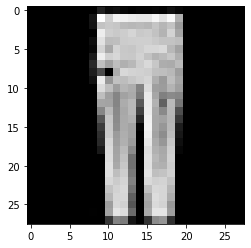

In [13]:
import cv2

test_img = 200

plt.imshow(x_test[200], cmap='gray')

test_img = x_test[test_img].reshape(1, 28, 28, 1)
test_pred = np.argmax(model.predict(test_img))
print(label_dict[test_pred])